<a href="https://colab.research.google.com/github/Dynamo-Dream/Generative-Adversial-Networks/blob/main/GAN_For_First_TIme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Flatten, BatchNormalization
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import numpy as np


ModuleNotFoundError: ignored

In [3]:
img_rows = 28
img_columns = 28
channels = 1
img_shape = (img_rows,img_columns,channels)

In [4]:
x,y = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
x[1][0]

5

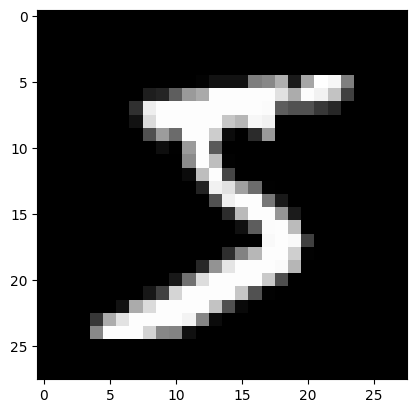

In [6]:
plt.imshow(x[0][0], cmap='gray')
plt.show()

In [7]:
def build_generator():
  noise_shape = (100,) #1d array of size 100 (latent vector/main)
  # Define Generator Network
  # Here we will simple Dense Network, but we can use VGG for Super Res GAN

  model = Sequential()
  model.add(Dense(256, input_shape = noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape=noise_shape)
  generated_img = model(noise)
  return Model(noise, generated_img)
  # Momentum speed up the Training
 #alpha- a is a hyperparameter which controls the underlying value to which function saturates negatives network input

In [16]:
# Given an input image the Discrimniator outputs the likelihood of the image being real.
# Binary Classificaiton - TRue or False (We are calling it Validity)
def build_discrimanator():
  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img,validity)

  #validity if the image is real or not


In [36]:
def save_imgs(epoch):
  r,c = 5,5
  noise = np.random.normal(0,1,(r*c,100))
  gen_imgs = generator.predict(noise)
  gen_imgs = 0.5*gen_imgs+0.5
  fig, axs = plt.subplots(r,c)
  cnt = 0

  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("/content/images/mnist_%d.png" %epoch)
  plt.close()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
optimizer = "adam"

discriminator = build_discrimanator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])

generator = build_generator()
generator.compile(loss="binary_crossentropy", optimizer=optimizer)

#THis build the generator and defines the input noise
# in GAN the generator network takes noise z as an input and produce its images
z = Input(shape=(100,))
img = generator(z)

#This ensures that when we train our networks we only train the Generator
# while generator training we do not want discriminator weights to be adjusted
#This Doesnot affect the above descriminator Training

discriminator.trainable = False
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [34]:
# Now lets make them Fight Together by defining training function, Loading the Data Set, Re-scaling our training images and setting the ground truths

def train(generator, descriminator, combined, epochs,batch_size=128,save_interval=500):
  (X_train,_), (_,_) = mnist.load_data()

  #COnvert to float and rescale -1 to 1
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  #Add Channels Dimension. As the input to our gen and discr has a shape of 28*28*1
  X_train = np.expand_dims(X_train,axis=3)

  half_batch = int(batch_size/2)
 # when we loop through a number of epochs to train our discriminator by first selectig a random batch of images from our true dataset, generating a set of images
 #from oor generator, feediing both set of images into our discrimniator and finally setting the loss parameters for both real and fake images

  for epoch in range(epochs):
  #Train Discrimantor

  # select a random half batch of real images

    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0,1,(half_batch,100))



    gen_imgs = generator.predict(noise)

    # Training the Descrimniator on real and fake images separetly as research shows much better

    d_loss_real = descriminator.train_on_batch(imgs,np.ones((half_batch,1)))
    d_loss_fake = descriminator.train_on_batch(gen_imgs,np.zeros((half_batch,1)))

    d_loss = 0.5*np.add(d_loss_real,d_loss_fake)

    # Within the Same loop we train our Generator, by setting the input noise and ultimately training the generator to have the Discriminator label its samples as valid
    # by specyfying gradient loss

    #----------------------
    # Train Generator
    #------------------------

    noise = np.random.normal(0,1,(batch_size,100))
  #The generator wants the discriminator to label the generated samples as vakid 1
  # Generator is trying to trick diiscrminator into beliving the generatod image is true
    valid_y = np.array([1]*batch_size)

  # Generator is part of combined where it got directly linked with the discrimnator
  #Train the generator with noise as and 1 as y

    g_loss = combined.train_on_batch(noise,valid_y)

    print("%d [D loss: %f, acc: %0.2f%%][G loss: %f]" %(epoch,d_loss[0], 100*d_loss[1],g_loss))

    if epoch % save_interval ==0:
      save_imgs(epoch)


In [ ]:
train(generator, discriminator, combined, epochs=100000, batch_size=32, save_interval=2000)
generator.save('generator_model_test.keras')

Streaming output truncated to the last 5000 lines.
35199 [D loss: 0.667119, acc: 53.12%][G loss: 1.137980]
1/1 [==============================] - 0s 33ms/step
35200 [D loss: 0.625735, acc: 71.88%][G loss: 0.979191]
1/1 [==============================] - 0s 31ms/step
35201 [D loss: 0.567284, acc: 65.62%][G loss: 1.131988]
1/1 [==============================] - 0s 30ms/step
35202 [D loss: 0.545468, acc: 71.88%][G loss: 1.005414]
1/1 [==============================] - 0s 28ms/step
35203 [D loss: 0.457304, acc: 81.25%][G loss: 1.523609]
1/1 [==============================] - 0s 24ms/step
35204 [D loss: 0.569087, acc: 71.88%][G loss: 1.566329]
1/1 [==============================] - 0s 26ms/step
35205 [D loss: 0.546854, acc: 75.00%][G loss: 1.333711]
1/1 [==============================] - 0s 26ms/step
35206 [D loss: 0.555363, acc: 75.00%][G loss: 1.135394]
1/1 [==============================] - 0s 25ms/step
35207 [D loss: 0.638471, acc: 59.38%][G loss: 1.176760]
1/1 [========================